In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import cv2

In [ ]:
import numpy as np
from scipy.stats import multivariate_normal

### ASSIGNMENT 1

In [ ]:
class GMM(object):

    weights = None
    means = None
    covars = None
    k=None
    iterations =100
    convergence_th=1e-3
    ric=None

    def __init__(self, n_components=1, tol=1e-3, max_iter=100):
        """
        A Gaussian mixture model trained via the expectation maximization
        algorithm.

        Parameters
        ----------

        n_components: The number of mixture components.
        tol: The convergence threshold
        """
        self.k=n_components
        self.iterations=max_iter
        self.convergence_th=tol


    def initialize_params(self, X, kmeans=False):
        """
        Initialize the starting GMM parameters.

        Parameters
        ----------
        X : A collection of `N` training data points, each with dimension `d`.
        kmeans: A boolean flag for determining if to initialize the params with kmeans or randomly.
        """

        self.means = np.random.rand(self.k,X.shape[1])
        self.covars = np.zeros((self.k, X.shape[1], X.shape[1]))
        for k in range(self.k):
            self.covars[k] = np.eye(X.shape[1])
        self.weights=[1/self.k]*self.k
        self.ric = np.zeros((X.shape[0], self.k))

    def formula(self,x,u,sigma,d):
        first_term = 1/(((2*np.pi)**(d/2))*np.sqrt(sigma))
        exp = -0.5*(np.dot(np.dot((x-u).T,np.linalg.inv(sigma)),(x-u)))
        second_term = np.exp(exp)
        return first_term*second_term

    def E_step(self, X):
        """
        Find the Expectation of the log-likelihood evaluated using the current estimate for the parameters

        Parameters
        ----------
        X : A collection of `N` data points, each with dimension `d`.
        """
        n=X.shape[0]
        d = X.shape[1]

        nan_mask = np.isnan(self.covars)
        inf_mask = np.isinf(self.covars)
        self.covars[nan_mask] = 1e-6
        self.covars[inf_mask] = 1e-6

        for c in range(self.k):
            self.ric[:,c]= self.weights[c]*multivariate_normal.pdf(X,mean=self.means[c],cov=self.covars[c],allow_singular=True)
        for i in range(n):
            self.ric[i] = self.ric[i]/np.sum(self.ric[i])
        return

    def M_step(self, X):
        """
        Updates parameters maximizing the expected log-likelihood found on the E step.

        Parameters
        ----------
        X : A collection of `N` data points, each with dimension `d`.
        """
        n=X.shape[0]
        d=X.shape[1]

        for c in range(self.k):
            self.weights[c]=np.sum(self.ric[:,c])/n

        for c in range(self.k):
            clusterSum = np.sum(self.ric[:, c])
            self.means[c] = np.sum(X * self.ric[:, c][:, np.newaxis], axis=0) / clusterSum
            diff = X - self.means[c]

            self.covars[c] = (np.dot(self.ric[:, c] * diff.T, diff)/ clusterSum)
            self.weights[c] = clusterSum / n



    def fit(self, X, y=None):
        """
        Fit the parameters of the GMM on some training data.

        Parameters
        ----------
        X : A collection of `N` training data points, each with dimension `d`.
        y: not used
        """
        self.initialize_params(X)
        for i in range(self.iterations):
            self.E_step(X)
            self.M_step(X)

    def predict(self, X):
        """
        Predict the labels for the data samples in X using trained model.

        Parameters
        ----------
        X : A collection of `M` data points, each with dimension `d`.

        Returns
        -------
        Predicted labels.
        """
        N = X.shape[0]
        gamma = np.zeros((N, self.k))
        for k in range(self.k):
            pdf = multivariate_normal(mean=self.means[k], cov=self.covars[k])
            gamma[:, k] = self.weights[k] * pdf.pdf(X)
        return np.argmax(gamma, axis=1)

### ASSIGNMENT 2

In [5]:
from google.colab import files
uploaded = files.upload()

Saving cow.jpg to cow.jpg


In [6]:
test_img = cv2.imread('cow.jpg')

In [ ]:
def plot_rgb(img, figsize=None, title=None, xlabel=None, ylabel=None, interpolation=None, save=False, save_name=None):
    eps = 0.0001

    img = img.astype(np.float64)
    img = (img - np.min(img)) / (np.max(img) - np.min(img) + eps)

    fig = plt.figure(num=None, figsize=figsize, dpi=100)
    fig.tight_layout()

    if interpolation != None:
        plt.imshow(img, interpolation = interpolation)
    else:
        plt.imshow(img)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    # plt.axis('off')

    if save:
        if save_name is None:
            save_name = title

        # plt.imsave(f'../imgs/{save_name}.png', img)
        plt.savefig(f'../results/{save_name}.png', bbox_inches='tight')

    plt.show()
    plt.close(fig)

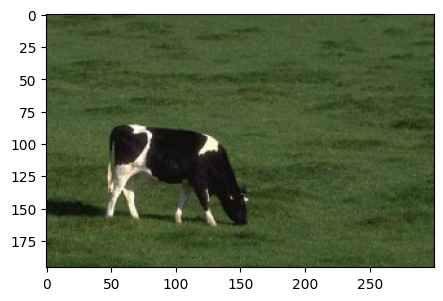

In [7]:
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

plot_rgb(test_img, figsize=(5, 5))

In [8]:
from sklearn.preprocessing import StandardScaler
X = np.reshape(test_img,(test_img.shape[0]*test_img.shape[1],test_img.shape[2]) )
sc = StandardScaler()
scaledX= sc.fit_transform(X)

In [9]:
X

array([[65, 83, 45],
       [68, 86, 48],
       [70, 88, 50],
       ...,
       [63, 85, 39],
       [60, 81, 38],
       [60, 81, 38]], dtype=uint8)

In [10]:
gmm = GMM(n_components=3,max_iter=10)

In [11]:
gmm.fit(scaledX)

In [12]:
gmm.means

array([[-1.20022551, -1.65719349, -0.94450778],
       [ 3.53196913,  2.69834157,  3.77812287],
       [ 0.03681487,  0.12643624, -0.00568957]])

In [13]:
pred= gmm.predict(scaledX)

In [14]:
pred.shape

(58800,)

In [15]:
np.newaxis

In [16]:
print(gmm.covars[0].shape,np.eye(3).shape)

(3, 3) (3, 3)


In [17]:
def plot_seg(img, figsize=None, cmap=None, title=None, xlabel=None, ylabel=None, save=False, save_name=None):
    """
    Funciton for Plotting Segmentation Maps.
    Expected Input: 2D Matrix of the size of the image containing just label values (1, 2, 3, ...) instead of [R, G, B] / Grayscale values.
    """

    img = np.copy(img)
    n_class = np.max(img) + 1 ## Could remove +1 depending on how you constructed segmented maps

    colors = []
    for i in range(n_class):
        colors.append(( np.random.randint(256), np.random.randint(256), np.random.randint(256)))

    colors = np.asarray(colors, dtype=np.uint8)


    fig = plt.figure(num=None, figsize=figsize, dpi=100, facecolor='w', edgecolor='k')
    fig.tight_layout()

    img = colors[img]

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    # plt.axis('off')

    if save:
        if save_name is None:
            save_name = title

        # plt.imsave(f'../imgs/{save_name}.png', img)
        plt.savefig(f'../results/{save_name}.png', bbox_inches='tight')

    plt.imshow(img, cmap=cmap)
    plt.show()

    plt.close(fig)

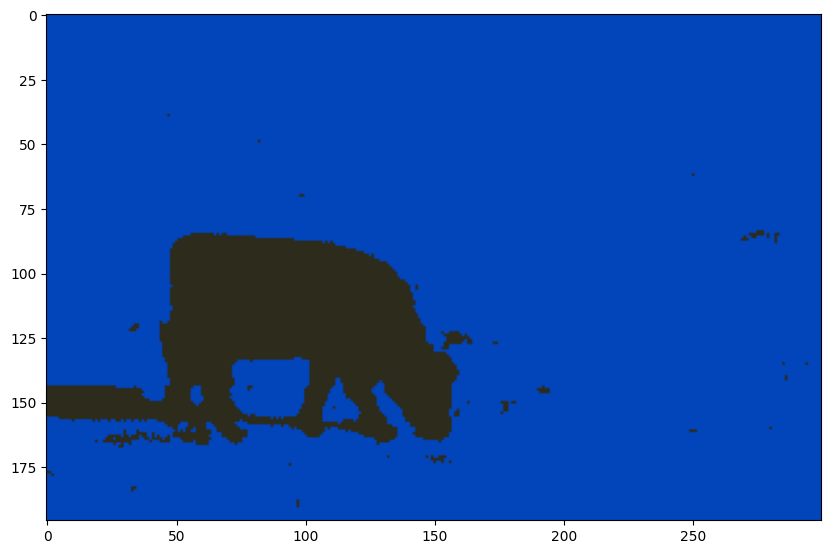

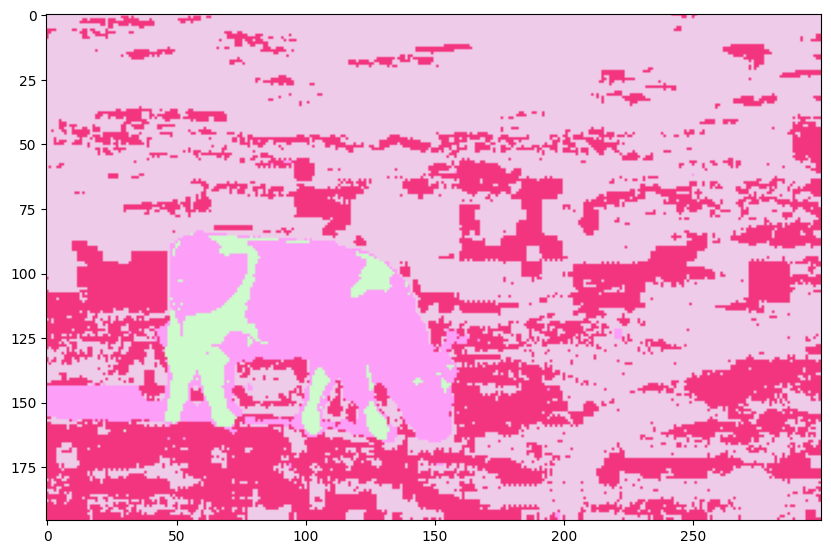

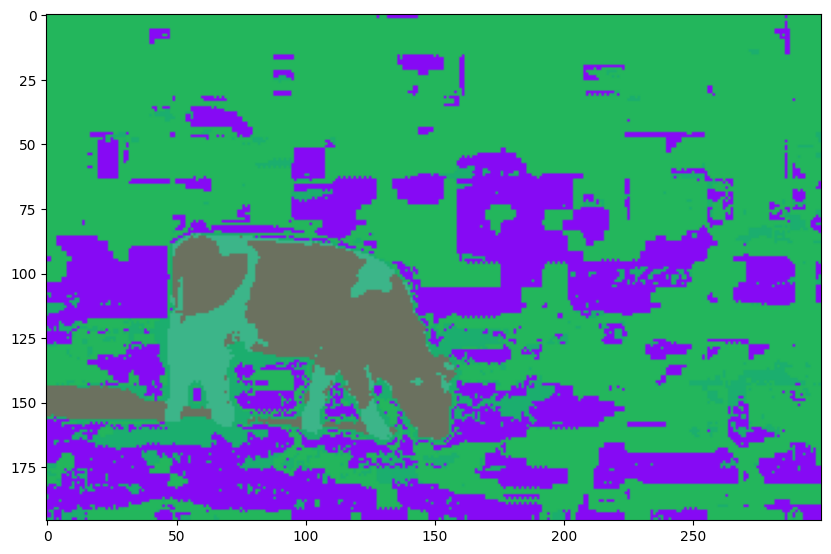

In [18]:
"""
Create and Fit Multiple GMMs corresponding to different number of components
"""
gmm = GMM(n_components=2,max_iter=10)
gmm.fit(scaledX)
pred= gmm.predict(scaledX)
plot_seg(np.reshape(pred,(test_img.shape[0],test_img.shape[1])), figsize=(10,10))
gmm = GMM(n_components=4,max_iter=10)
gmm.fit(scaledX)
pred= gmm.predict(scaledX)
plot_seg(np.reshape(pred,(test_img.shape[0],test_img.shape[1])), figsize=(10,10))
gmm = GMM(n_components=5,max_iter=10)
gmm.fit(scaledX)
pred= gmm.predict(scaledX)
plot_seg(np.reshape(pred,(test_img.shape[0],test_img.shape[1])), figsize=(10,10))

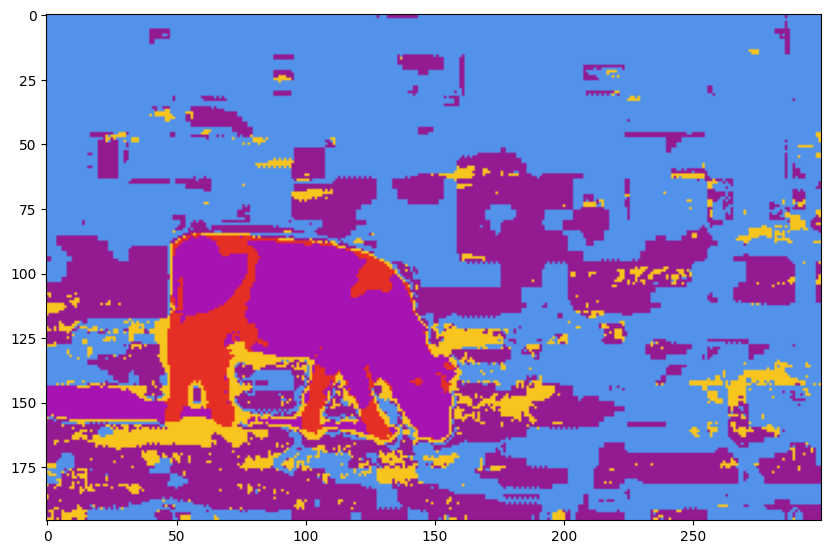

In [19]:
plot_seg(np.reshape(pred,(test_img.shape[0],test_img.shape[1])), figsize=(10,10))